# Reproducing a Figure from a previous publication

In this notebook, we will demonstrate how to reproduce a figure from a previous publication, based on an AFQ-Browser instance

The data are described in [a paper by Sarica et al. (2017)](http://onlinelibrary.wiley.com/doi/10.1002/hbm.23412/abstract), and contains diffusion MRI (dMRI) images from brains of participants with ALS and matched control subjects. 

The AFQ-browser instance that displays these data can be found at: https://yeatmanlab.github.io/Sarica_2017

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Download

We download the data directly from the AFQ-Browser website. 

One file contains the processed dMRI data, in the form of a 'tidy' table that describes several diffusion statistics (such as MD, FA, etc.) along the length of the 20 different fiber groups that AFQ analyzes. 

The `pandas` library allows us to read the data directly from the URL (but we could also use the "download data" buttons, if we wish to save the data locally): 

In [3]:
df_nodes = pd.read_csv("http://yeatmanlab.github.io/Sarica_2017/data/nodes.csv")

Another table contains metadata about the subjects (for example whether they are patients or controls):

In [4]:
df_subjects = pd.read_json("http://yeatmanlab.github.io/Sarica_2017/data/subjects.json")

We use `pandas` to merge the two tables together

In [5]:
df = pd.merge(df_nodes, df_subjects, on="subjectID")

In [8]:
colors = {'ALS': 'b', 'CTRL': 'r'}

In [9]:
tracts = ['Left Corticospinal', 'Right Corticospinal']

In [27]:
from scipy.stats import ttest_ind

/Users/arokem/anaconda3/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/arokem/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/arokem/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/arokem/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


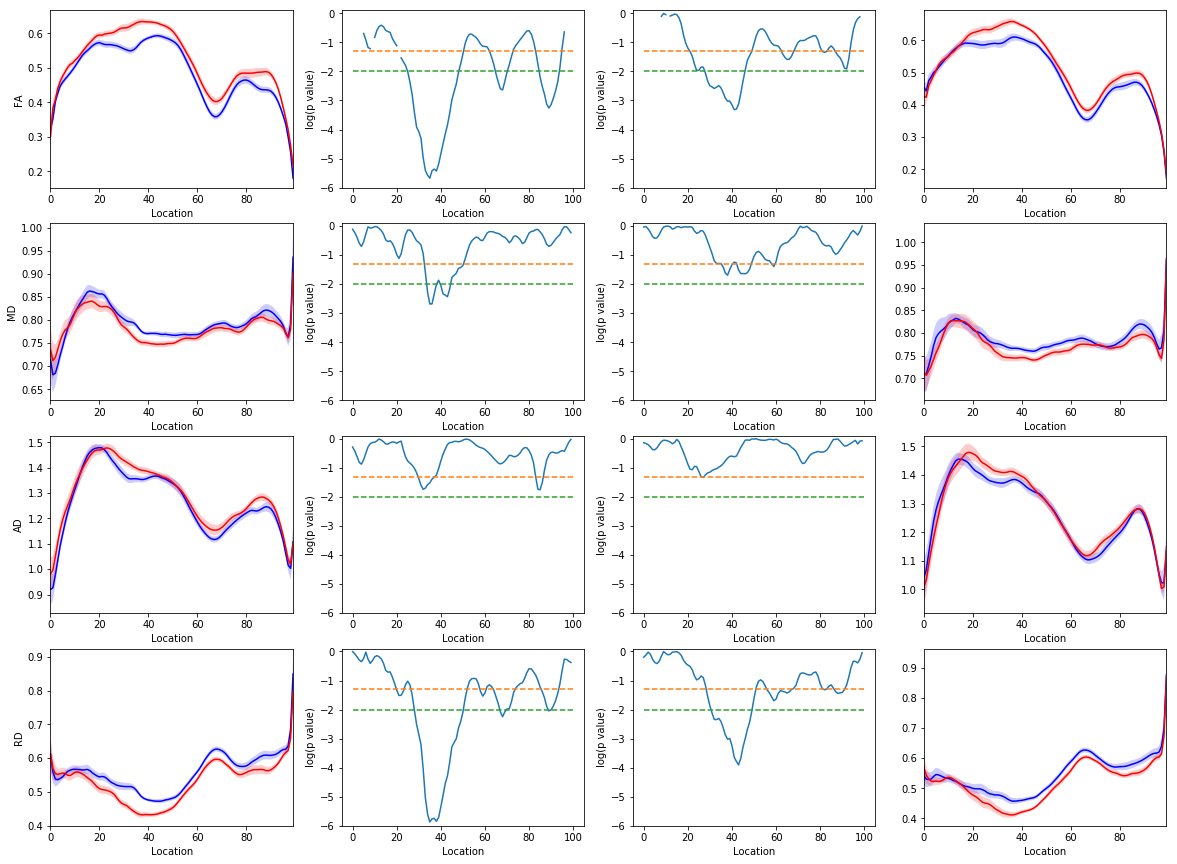

In [75]:
fig, ax = plt.subplots(4, 4)
for stat_idx, stat in enumerate(['fa', 'md', 'ad', 'rd']):
    for tract_idx, tract_name in enumerate(tracts):
        # Select the tract of interest
        tract_df = df[df['tractID'] == tract_name]
        # Group them by patients vs. controls
        gb_als = tract_df.groupby('class')
        # Plot the values of the statistic for every individual and across groups
        for c, df_c in gb_als:
            tract_p = df_c.pivot(index='nodeID', columns='subjectID', values=stat) 
            sns.tsplot(tract_p.values.T, ax=ax[stat_idx, -tract_idx], 
                       color=colors[c], estimator=np.nanmean)
        
        ax[stat_idx, 0].set_ylabel(stat.upper())
        tract_als = tract_df[tract_df['class'] == 'ALS']
        tract_ctrl = tract_df[tract_df['class'] == 'CTRL']
        tract_als_stat = tract_als.pivot(index='nodeID', columns='subjectID', values=stat)
        tract_ctrl_stat = tract_ctrl.pivot(index='nodeID', columns='subjectID', values=stat) 
        p = ttest_ind(tract_als_stat, tract_ctrl_stat, axis=-1)[1]
        ax[stat_idx, tract_idx + 1].plot(p)
        #ax[stat_idx, tract_idx + 1].set_ylim([-6, 0.1])
        ax[stat_idx, tract_idx + 1].plot([0, 100], [np.log10(0.05), np.log10(0.05)], '--')
        ax[stat_idx, tract_idx + 1].plot([0, 100], [np.log10(0.01), np.log10(0.01)], '--')
        ax[stat_idx, tract_idx + 1].set_ylabel('log(p value)')
    # Set the x axis labels for all the sub-plots:
    for ii in range(4):
        ax[stat_idx, ii].set_xlabel('Location')
    
fig.set_size_inches(20, 15)